#### I need to get a video and detections to extract crops with color

In [ ]:
! scp -r i.nogueiras@cluster-ceab.ceab.csic.es:/leov1/ants2024/detections/bgfg_x264_stack_20240708_PINK-YELLOW_LR-SR .
! scp -r i.nogueiras@cluster-ceab.ceab.csic.es:/leov1/ants2024/videos_experiments/x264_stack_20240708_PINK-YELLOW_LR-SR .

#### New detections

In [1]:
! python3 ~/ANTS/src3_detection/wp1_training/background_trainer.py ~/data/videos_learning/20241018/20241018_1310_0000_00.mkv background.png

Frame 4801 is None


In [ ]:
! python3 ~/ANTS/src3_detection/wp2_inference/ant_detection_bgfg_oriented.py ~/data/videos_learning/20241018/20241018_1324_0000_00.mkv ~/data/videos_learning/20241018_1324_0000_00.txt --start_write=200
! python3 ~/ANTS/src3_detection/wp2_inference/ant_detection_bgfg_oriented.py ~/data/videos_learning/20241018/20241018_1341_0000_00.mkv ~/data/videos_learning/20241018_1341_0000_00.txt --start_write=200

In [ ]:
! python3 ~/ANTS/src8_tracking/wp0_inference/ocsort_track_oriented.py ~/data/videos_learning/20241018_1324_0000_00.txt ~/data/videos_learning/20241018_1324_0000_00_trk.txt --associationFunc=giou
! python3 ~/ANTS/src8_tracking/wp0_inference/ocsort_track_oriented.py ~/data/videos_learning/20241018_1341_0000_00.txt ~/data/videos_learning/20241018_1341_0000_00_trk.txt --associationFunc=giou

#### I need to extract the color crops

I used ground truth too

In [4]:
! python3 ~/ANTS/src5_colors/wp1_dataset/crop_ids_as_color.py ~/data/videos_learning/20241018/color_20241018_1324_0000_00.mkv ~/data/videos_learning/20241018_1324_0000_00_gt.txt ./crops/ --downsampling=40 --red=7 --green=2 --green=0 --pink=8

Reading row 5000000 for last_frame
Processing frame 40 / 9013
^C
Traceback (most recent call last):
  File "/home/ignasi/ANTS/src5_colors/wp1_dataset/crop_ids_as_color.py", line 76, in <module>
    _, frame = capture.read()
               ^^^^^^^^^^^^^^
KeyboardInterrupt


I further classified the color crops into crops I'm able to see the color and crops I know have colors because I saw the same ID with that color

#### Create annotations from folder-tree

In [ ]:
! python ~/ANTS/src5_colors/wp1_dataset/create_dataset_from_folders.py /home/ignasi/data/color_crops/ ./crop_colores_all.txt --color=black --color=green --color=pink --color=red --by_id --label
! python ~/ANTS/src5_colors/wp1_dataset/create_dataset_from_folders.py /home/ignasi/data/color_crops/ ./crop_colores.txt --color=black --color=green --color=pink --color=red --label

#### Color histogram observation

I want to see each bin as a feature and I know the range of each color. I will add "maximum of the range plus one" (256) times the color channel index and flatten the data.

I have different number of pixels per image, so I will normalize the histograms by the total number of color values (3 * number of pixels). The number of pixels is not equal from ant to ant and the position of the ant may modify it. However, if a crop has a high number of color pixels, it may be useful too.

I have different number of images per class, so I will normalize the addition of pixel normalized histograms by the number of images.

I need to plot each color class within an axe, so each color class histogram should have that color.

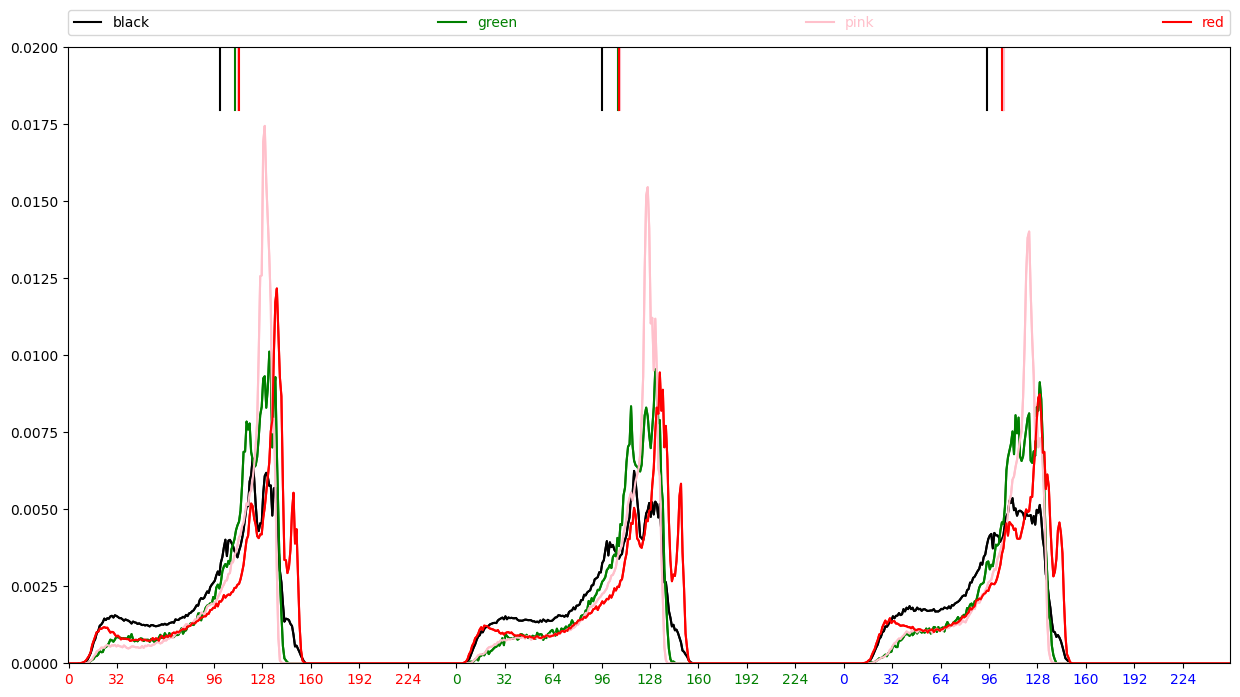

In [9]:

import matplotlib
import numpy as np

from ceab_ants.colors.plots.color_histogram import prepare_canvas, dataset_hist
from ceab_ants.io.crop_loader import ColorCropLoader


matplotlib.rcParams['figure.figsize'] = [15, 8]


INPUT = './crop_colores.txt'
DATA_PATH = '/home/ignasi/data/color_crops'
YLIM = 0.02
YSEP = 0.2
OK_FILTER = []
HIST = False


dataset = ColorCropLoader(INPUT, DATA_PATH, labels=True)
fig, ax, nbins, range_, hist_bins = prepare_canvas(bins_per_color=256, colors=3, ticks_per_color=8, colormap=["red", "green", "blue"])

histograms = dataset_hist(dataset, nbins, range_, norm=True)

colors = []
ymin = 0
for color, values in histograms.items():

    if (len(OK_FILTER) > 0) and (color not in OK_FILTER) : continue
    color_hist = np.sum(values, axis=0) / len(values)
    histograms[color] = color_hist
    if HIST:
        _ = ax.bar(hist_bins, color_hist, color=color, label=color)
    else:
        ax.plot(color_hist, color=color, label=color)

    ymin = np.maximum(ymin, (1 - YSEP) * np.max(color_hist) / YLIM + YSEP)

    colors.append(color)

_ = ax.legend(labelcolor=colors, bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=len(colors))
_ = ax.set_xlim(0, 256 * 3)
_ = ax.set_ylim(0, YLIM)

for color, color_hist in histograms.items():
    if (len(OK_FILTER) > 0) and (color not in OK_FILTER) : continue

    if not HIST : ax.plot(color_hist, color=color)
    
    compute_mean = lambda hist : np.average(hist_bins[:256], weights=hist, axis=0)
    ax.axvline(compute_mean(color_hist[:256]), color=color, ymin=ymin)
    ax.axvline(compute_mean(color_hist[256 : 256 * 2]) + 256, color=color, ymin=ymin)
    ax.axvline(compute_mean(color_hist[256 * 2 : 256 * 3]) + 256 * 2, color=color, ymin=ymin)


Jo veig 2 gaussianes, una pel negre, al voltant del nivell (32, 32, 32) on el pes te més importancia (negre) i una pel color al voltant del nivell (128, 128, 128) on la mitja (rosa vs vermell) i la variancia (verd) tenen més importancia.

In [ ]:

from collections import defaultdict
import numpy as np

from ceab_ants.colors.plots.color_histogram import dataset_hist
from ceab_ants.io.crop_loader import ColorCropLoader


INPUT = './crop_colores.txt'
DATA_PATH = '/home/ignasi/data/color_crops'


nbins = 256 * 3
range_ = [0, nbins]
hist_bins = np.histogram([], bins=nbins, range=range_)[1][:257] # 0 to 256 both included
hist_bins = (hist_bins[:-1] + hist_bins[1:] / 2)
hist_bins = np.repeat(hist_bins.reshape(-1, 1), 3, axis=-1)


dataset = ColorCropLoader(INPUT, DATA_PATH, labels=True)
histograms = dataset_hist(dataset, nbins, range_, norm=True)

# Mean and Std of image pixels of a class
hist_data = defaultdict(list)
for color, values in histograms.items():

    color_hist = np.sum(values, axis=0) / len(values)

    rgb_hist = np.stack([color_hist[256 * i : 256 * (i + 1)] for i in range(3)], axis=-1)

    mean = np.average(hist_bins, weights=rgb_hist, axis=0)
    std = np.sqrt(np.average((hist_bins - mean) ** 2, weights=rgb_hist, axis=0))

    hist_data[color].extend([mean, std, np.diag(std)])

    print(f'{color} mean: {mean}\n{color} std: {std}', end='\n\n')


black mean: [133.32727888 133.30872673 133.06508377]
black std: [20.00662568 19.77165546 19.65998143]

green mean: [134.20093724 134.08985957 134.85653077]
green std: [19.86700097 19.69033818 19.6480938 ]

pink mean: [133.34073903 133.07388865 133.5921896 ]
pink std: [19.32435178 19.78693413 20.05296742]

red mean: [131.90297305 131.9372826  133.27588628]
red std: [19.7614908  19.71181434 19.87069628]



In [2]:

from collections import defaultdict
import numpy as np

from ceab_ants.io.crop_loader import ColorCropLoader


INPUT = './crop_colores.txt'
DATA_PATH = '/home/ignasi/data/color_crops'


dataset = ColorCropLoader(INPUT, DATA_PATH, labels=True)

# Mean and Std of image pixels
img_data = defaultdict((list))
color_levels = defaultdict((list))
for img, color in dataset:
    img_data[color].extend([np.mean(img, axis=(0, 1)), np.std(img, axis=(0, 1))])
    color_levels[color].append(img.reshape(-1, 3))

# Mean and Std of class pixels (not image pixels of a class)
color_data = defaultdict((list))
for color, levels in color_levels.items():
    pixels = np.concatenate(levels, axis=0)
    color_data[color].extend([np.mean(pixels, axis=0), np.cov(pixels.T), np.std(pixels, axis=0)])

for color, data in color_data.items():
    print(f'{color} mean: {data[0]}\n{color} std: {data[2]}\n{color} cov: \n{data[1]}', end='\n\n')


black mean: [108.12005711 104.74195676 102.50771018]
black std: [33.23912026 33.6380352  29.67158076]
black cov: 
[[1104.8395452  1105.56847822  956.43804288]
 [1105.56847822 1131.5178516   989.77334491]
 [ 956.43804288  989.77334491  880.40304678]]

green mean: [112.05595983 109.44981299 107.50877104]
green std: [27.26681769 27.12528791 24.19264794]
green cov: 
[[743.48690312 728.34372381 634.94932165]
 [728.34372381 735.78872231 650.06231069]
 [634.94932165 650.06231069 585.29016303]]

pink mean: [113.37650139 109.30761484 107.512467  ]
pink std: [26.31995594 27.96642974 24.93566606]
pink cov: 
[[692.74191647 718.41771792 621.64882641]
 [718.41771792 782.12326507 689.57064251]
 [621.64882641 689.57064251 621.78908963]]

red mean: [117.19618756 113.24719569 109.72369257]
red std: [33.38182246 35.2431276  31.34428356]
red cov: 
[[1114.34815242 1158.81186299 1012.50124292]
 [1158.81186299 1242.08036344 1095.2849778 ]
 [1012.50124292 1095.2849778   982.46594762]]



In [3]:

from scipy.stats import multivariate_normal

logpdf_black_black = multivariate_normal(mean=hist_data['black'][0], cov=hist_data['black'][1]).logpdf(img_data['black'])
logpdf_black_red = multivariate_normal(mean=hist_data['black'][0], cov=hist_data['black'][1]).logpdf(img_data['red'])

logpdf_red_black = multivariate_normal(mean=hist_data['red'][0], cov=hist_data['red'][1]).logpdf(img_data['black'])
logpdf_red_red = multivariate_normal(mean=hist_data['red'][0], cov=hist_data['red'][1]).logpdf(img_data['red'])

print(np.min(logpdf_black_black), np.max(logpdf_black_black), np.median(logpdf_black_black))
print(np.min(logpdf_black_red), np.max(logpdf_black_red), np.median(logpdf_black_red))
print()
print(np.min(logpdf_red_black), np.max(logpdf_red_black), np.median(logpdf_red_black))
print(np.min(logpdf_red_red), np.max(logpdf_red_red), np.median(np.max(logpdf_red_red)))
print()
print(sum(logpdf_red_red > logpdf_black_red), ' / ', len(img_data['red']))
print(sum(logpdf_black_black > logpdf_red_black), ' / ', len(img_data['black']))


-640.1193710131138 -26.892310246026796 -460.69406703035855
-584.6325088929237 -27.813439904406714 -408.3671364966087

-728.9437713013434 -48.93941378465921 -539.4724703565462
-670.7921721821127 -50.36226073109141 -50.36226073109141

0  /  392
2712  /  2712


In [23]:

from collections import defaultdict
import numpy as np
from sklearn import mixture

from ceab_ants.io.crop_loader import ColorCropLoader


INPUT = './crop_colores.txt'
DATA_PATH = '/home/ignasi/data/color_crops'


dataset = ColorCropLoader(INPUT, DATA_PATH, labels=True)
loaded_dataset = defaultdict(list)
for img, color in dataset:
    loaded_dataset[color].append(img.reshape(-1, 3))

# Pixel color distribution
models = dict()
for color, data in loaded_dataset.items():
    models[color] = mixture.GaussianMixture(n_components=2, covariance_type="full", max_iter=1000, n_init=1, means_init=[[32, 32, 32], [128, 128, 128]], verbose=2)
    models[color].n_features_in_ = 3 
    models[color].feature_names_in_ = ["red", "green", "blue"]
    models[color].fit(np.concatenate(data))


Initialization 0
  Iteration 10	 time lapse 8.25743s	 ll change 0.00203
Initialization converged. time lapse 9.84304s	 lower bound -9.96140.
Initialization 0
  Iteration 10	 time lapse 0.56432s	 ll change 0.00650
Initialization converged. time lapse 0.71745s	 lower bound -9.42756.
Initialization 0
  Iteration 10	 time lapse 1.96448s	 ll change 0.00452
Initialization converged. time lapse 2.53161s	 lower bound -9.53199.
Initialization 0
  Iteration 10	 time lapse 2.21047s	 ll change 0.01982
Initialization converged. time lapse 3.43699s	 lower bound -9.94607.


In [24]:
# Pixel color distribution
models = dict()
for color, data in loaded_dataset.items():
    models[color] = mixture.GaussianMixture(n_components=4, covariance_type="full", max_iter=1000, n_init=10, verbose=False)
    models[color].n_features_in_ = 3 
    models[color].feature_names_in_ = ["red", "green", "blue"]
    models[color].fit(np.concatenate(data))

print(models["black"].means_)

[[ 38.66192702  35.91715933  44.18351383]
 [134.00681509 131.81157603 127.14694287]
 [114.7348026  111.05295091 106.95252752]
 [ 86.50142949  80.60524004  79.87187657]]


Fan falta 4 gaussianes perque es coloquin en les zones de 32 i 128

In [39]:

logpdf_red_red = np.array([models["red"].score(flat_img) for flat_img in loaded_dataset["red"]])
logpdf_black_red = np.array([models["black"].score(flat_img) for flat_img in loaded_dataset["red"]])

logpdf_black_black = np.array([models["black"].score(flat_img) for flat_img in loaded_dataset["black"]])
logpdf_red_black = np.array([models["red"].score(flat_img) for flat_img in loaded_dataset["black"]])

print("Red over Black: \t", sum(logpdf_red_red > logpdf_black_red), ' / ', len(loaded_dataset['red']))
print("Black over Red: \t", sum(logpdf_black_black > logpdf_red_black), ' / ', len(loaded_dataset['black']))

Red over Black: 	 178  /  196
Black over Red: 	 1181  /  1356


In [40]:
logpdf_red_red = np.array([models["red"].score(flat_img) for flat_img in loaded_dataset["red"]])
logpdf_pink_red = np.array([models["pink"].score(flat_img) for flat_img in loaded_dataset["red"]])

logpdf_pink_pink = np.array([models["pink"].score(flat_img) for flat_img in loaded_dataset["pink"]])
logpdf_red_pink = np.array([models["red"].score(flat_img) for flat_img in loaded_dataset["pink"]])

print("Red over Pink: \t", sum(logpdf_red_red > logpdf_pink_red), ' / ', len(loaded_dataset['red']))
print("Pink over Red: \t", sum(logpdf_pink_pink > logpdf_red_pink), ' / ', len(loaded_dataset['pink']))

Red over Pink: 	 192  /  196
Pink over Red: 	 148  /  148


In [55]:
import dill


with open("red_gmm.dill", 'wb') as f:
    dill.dump(models["red"], f)

with open("red_gmm.dill", 'rb') as f:
    m = dill.load(f)


print(m is models["red"])
m


False


GaussianMixture(max_iter=1000, n_components=4, n_init=10, verbose=False)

### Test train program

In [13]:
! python3 ~/ANTS/src5_colors/wp1_dataset/split_per_color_dataset.py crop_colores.txt --probs=70 --names=train_70-30.txt --probs=30 --names=val_70-30.txt

0 ---- 949
949 ---- 1356
0 ---- 28
28 ---- 40
0 ---- 103
103 ---- 148
0 ---- 137
137 ---- 196


In [18]:
! python3 ~/ANTS/src5_colors/wp2_training/train_colors.py "train_70-30.txt" ~/data/color_crops/ "first_models" --verbose=8

first_models_black.dill
first_models_green.dill
first_models_pink.dill
first_models_red.dill


In [33]:
! python3 ~/ANTS/src5_colors/wp3_inference/classify_colors.py first_models_*.dill --dataset_path=val_70-30.txt --data_path=/home/ignasi/data/color_crops/ --output=pred_val_70-30.txt
! python3 ~/ANTS/src5_colors/wp3_inference/classify_colors.py scores first_models_*.dill --dataset_path=val_70-30.txt --data_path=/home/ignasi/data/color_crops/ --output=scores_val_70-30.txt --colors=black --colors=blue --colors=green --colors=red --colors=pink --colors=white